In [19]:
import pandas as pd


train_data = pd.read_csv("/Users/dhanalakshmijothi/Desktop/Kaggle/titanic/train.csv")
test_data = pd.read_csv("/Users/dhanalakshmijothi/Desktop/Kaggle/titanic/test.csv")

print(train_data.head())
print(test_data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  


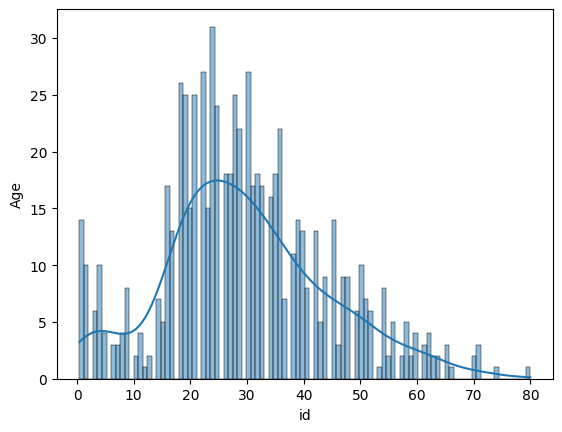

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

missing_values = train_data.isnull().sum()
print(missing_values)

outlier = train_data.describe()
print(outlier)

#AGE, CABIN, EMBARKED HAS MISSING VALUES

train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])
test_data['Embarked'] = test_data['Embarked'].fillna(test_data['Embarked'].mode()[0])

train_data['Cabin_deck'] = train_data['Cabin'].str[0]
test_data['Cabin_deck'] = test_data['Cabin'].str[0]

train_data['Cabin_deck'] = train_data['Cabin_deck'].fillna('U')
test_data['Cabin_deck'] = test_data['Cabin_deck'].fillna('U')

Age_distribution = pd.DataFrame ({
    'id': train_data['PassengerId'],
    'Age': train_data['Age']
})

sns.histplot(Age_distribution, x='Age', bins=100, kde=True)
plt.xlabel('id')
plt.ylabel('Age')
plt.show

train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].median())

train_data['Family_size'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['Family_size'] = test_data['SibSp'] + test_data['Parch'] + 1

train_data['Sex'] = train_data['Sex'].map({'male':0, 'female':1})
test_data['Sex'] = test_data['Sex'].map({'male':0, 'female':1})


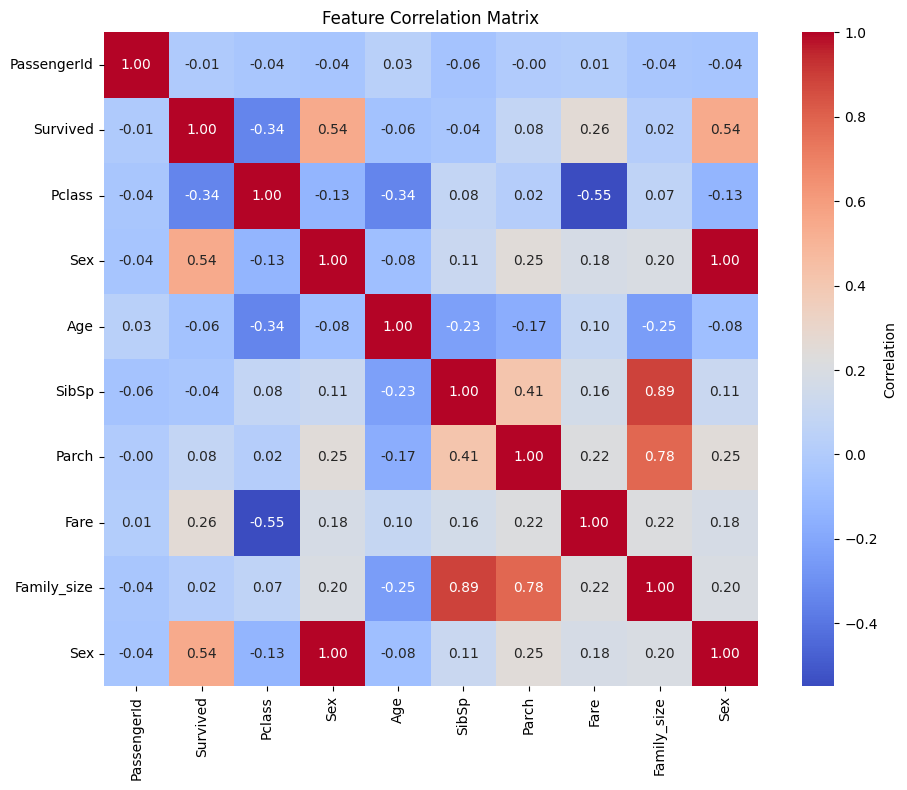

In [21]:
numeric_val = train_data.select_dtypes(include='number')
cate_val = pd.get_dummies(train_data[['Sex']], drop_first=True)

combined_data = pd.concat([numeric_val, cate_val], axis=1)

corr_matrix = combined_data.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,
            cmap='coolwarm',
            annot=True,
            fmt='.2f',
            square=True,
            cbar_kws={'label': 'Correlation'}
)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = train_data.drop(columns = ['PassengerId', 'Survived', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'])
Y = train_data['Survived']
X_test = test_data.drop(columns =['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'])

Encoder = LabelEncoder()
X['Cabin_deck'] = Encoder.fit_transform(X['Cabin_deck'])
X_test['Cabin_deck'] = Encoder.transform(X_test['Cabin_deck'])

X['Embarked'] = Encoder.fit_transform(X['Embarked'])
X_test['Embarked'] = Encoder.fit_transform(X_test['Embarked'])

# Split the data into training and validation sets
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)


Cross-validation scores: [0.78321678 0.83216783 0.79577465 0.81690141 0.85211268]
Accuracy on validation set: 0.8268


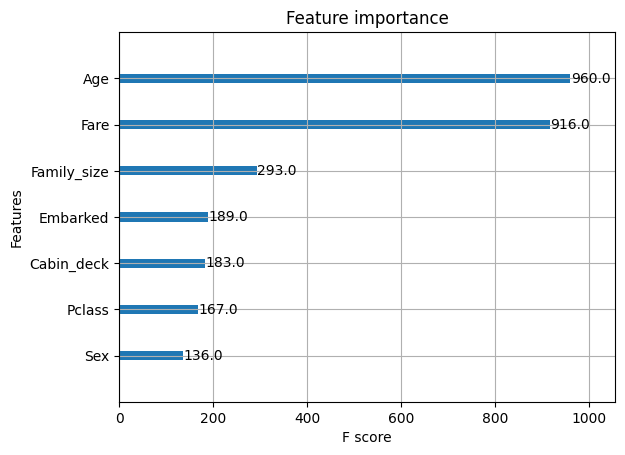

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

model = xgb.XGBRFClassifier()

cv_scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='accuracy')
print(f'Cross-validation scores: {cv_scores}')

model.fit(X_train, Y_train)

X_train_pred = model.predict(X_train)
X_valid_pred = model.predict(X_valid)

accuracy = accuracy_score(Y_valid, X_valid_pred)
print(f'Accuracy on validation set: {accuracy:.4f}')

X_test_pred = model.predict(X_test)

xgb.plot_importance(model)
plt.show()

submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': X_test_pred
})

submission.to_csv('/Users/dhanalakshmijothi/Desktop/Kaggle/titanic/submission.csv', index=False)
